In [1]:
import pbdlib as pbd
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from scipy.linalg import block_diag
%matplotlib inline
%load_ext autoreload
%autoreload 2
plt.style.use("default")
plt.rcParams['font.size'] = 13
plt.rcParams['axes.linewidth'] = 1.5
np.set_printoptions(precision=5, suppress=False)
plt.rcParams["figure.figsize"] = (4,3)

In [2]:
x_dim = 2
u_dim = x_dim
nb_deriv = 2 #[position, velocity]
demo_number = 4
T = 5.
horizon = 1000
dt = T/horizon
A, B = pbd.utils.get_canonical(x_dim, nb_deriv=nb_deriv, dt=dt) 

lqr = pbd.LQR(A, B, nb_dim=A.shape[0], dt=dt, horizon=horizon)
print(dt)

0.005


In [5]:
# Set via-points
via1 = np.array([-0.8, 0.5, 0, 0])[:x_dim*nb_deriv]
via2 = np.array([0.2, -0.5, 0, 0])[:x_dim*nb_deriv]
x_final_target = np.array([-0.75, -0.75, 0, 0])[:x_dim*nb_deriv]

zs = np.stack([
        via1,
        via1,
        via2,
        via2,
        x_final_target,
        x_final_target
    ]) # these are double becuase we will assign 0 precision for the first one, and bigger precision for the other

lqr.z = zs

In [6]:
# set the timing of the viapoints
via_time1 = int(horizon*0.4)
via_time2 = int(horizon*0.7)
seq =  ((via_time1-1) * [0] + 1 * [1] + (via_time2-via_time1-1)* [2] + 1 * [3] +(horizon-via_time2-1)*[4] + 1*[5] )
lqr.seq_xi = seq

In [7]:
# set the precisions

# Control precision R
u_std = -3. # means 1e-3
lqr.gmm_u = u_std

# Tracking precision
x_std = 1e6
dx_std = 1e2
Qs = np.stack([
    np.diag([0., 0., 0., 0.]),
    np.diag([x_std, x_std,0,0  ]),
    np.diag([0., 0.,0,0]),
    np.diag([x_std, x_std,0,0 ]),
    np.diag([0., 0., 0, 0]),
    np.diag([x_std, x_std,dx_std,dx_std])
    ])
lqr.Q = Qs

In [8]:
lqr.ricatti()

In [9]:
demo_number = 10
x0 = np.zeros((demo_number, x_dim*nb_deriv))
# xs,us = lqr.make_rollout_samples(x0)
xs,us = lqr.make_rollout(x0)

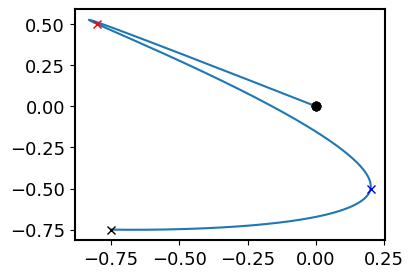

In [10]:
fig,ax = plt.subplots( figsize=(4,3))
xs_mean = np.mean(xs, axis=0) 
xs_std  = np.std(xs, axis=0)
ax.plot(xs_mean[:,0], xs_mean[:,1] )

ax.plot(via1[0], via1[1], "rx")
ax.plot(via2[0], via2[1], "bx")

ax.plot(x_final_target[0],x_final_target[1], "kx")
ax.plot(x0[0],x0[1], "ko")